# EDA

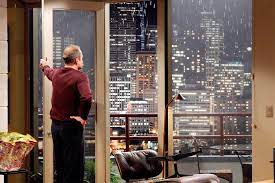

### 1. Setup & Imports

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from shapely.geometry import Point
import seaborn as sns
import pgeocode
import fiona
import pyproj

from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### 2. Data Loading & Cleaning

In [2]:
#load filtered data

df = pd.read_csv('data/filtered_after_data_cleaning.csv')

df["house_id"].duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
21592    False
21593    False
21594    False
21595    False
21596    False
Name: house_id, Length: 21597, dtype: bool

In [3]:
# ============
# 3. Data Quality Checks
# ============
# print(df.info())
# print(df.describe())
# print(df.isnull().sum())
print(df.head())

# Basic cleaning
# df.fillna({'yr_renovated': 0, 'waterfront': 0}, inplace=True)

         date      price    house_id  sale_id  bedrooms  bathrooms  \
0  2014-10-13 221900.000  7129300520        1     3.000      1.000   
1  2014-12-09 538000.000  6414100192        2     3.000      2.250   
2  2015-02-25 180000.000  5631500400        3     2.000      1.000   
3  2014-12-09 604000.000  2487200875        4     4.000      3.000   
4  2015-02-18 510000.000  1954400510        5     3.000      2.000   

   sqft_living  sqft_lot  floors  waterfront  ...  sqft_basement  yr_built  \
0     1180.000  5650.000   1.000       0.000  ...          0.000      1955   
1     2570.000  7242.000   2.000       0.000  ...        400.000      1951   
2      770.000 10000.000   1.000       0.000  ...          0.000      1933   
3     1960.000  5000.000   1.000       0.000  ...        910.000      1965   
4     1680.000  8080.000   1.000       0.000  ...          0.000      1987   

   yr_renovated  zipcode    lat     long  sqft_living15  sqft_lot15  \
0             0    98178 47.511 -122.25

In [4]:
#Feature

df["renovated"] = (df["yr_renovated"] > 0).astype(int)
df["price_per_sqft"] = df["price"] / df["sqft_living"]

### 3. Data Analysis

#### Price Distribution

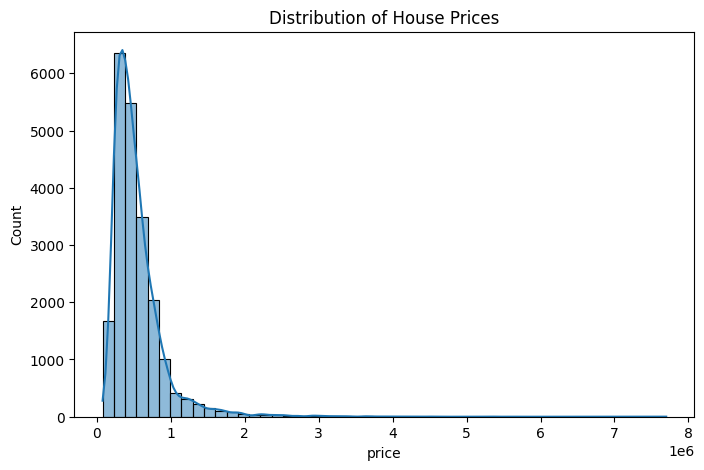

In [5]:
#check price distribution to check to target for resale

sns.histplot(df["price"], bins=50, kde=True)
plt.title("Distribution of House Prices")
plt.show()

#### Price vs. Grade

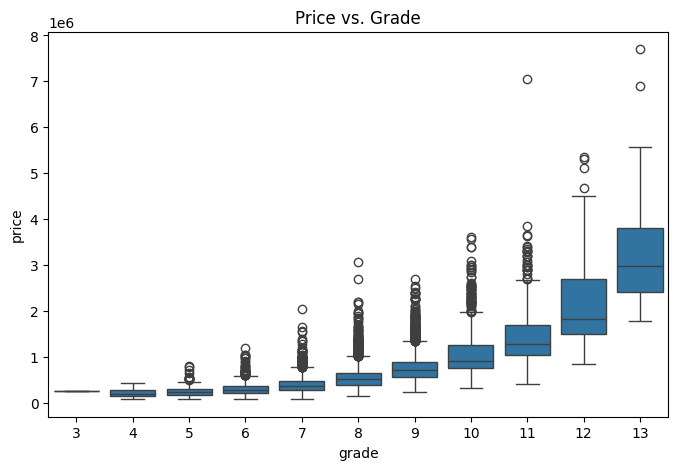

In [6]:
# Check price relation with Grade. High Grade = Higher Price

sns.boxplot(x="grade", y="price", data=df)
plt.title("Price vs. Grade")
plt.show()

#### Price Correlation with Features

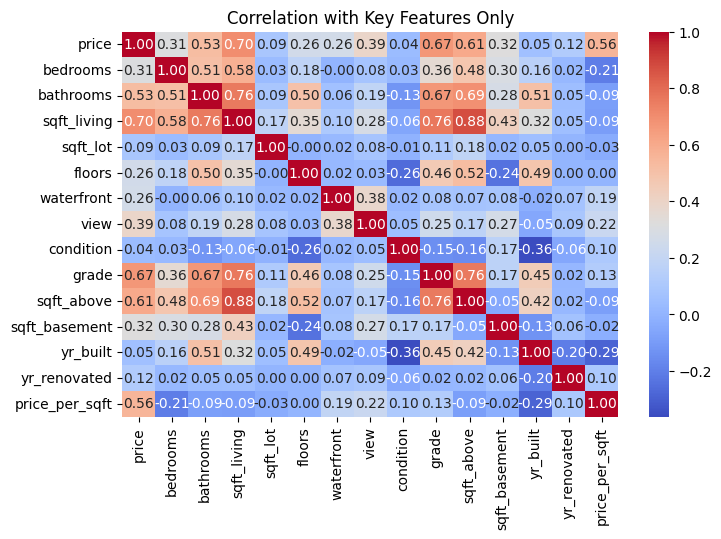

In [7]:
corr_features = [
    'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
    'floors', 'waterfront', 'view', 'condition', 'grade',
    'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'price_per_sqft'
]

sns.heatmap(df[corr_features].corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation with Key Features Only")
plt.show()

##### Price Correlation with top 10 Property Features

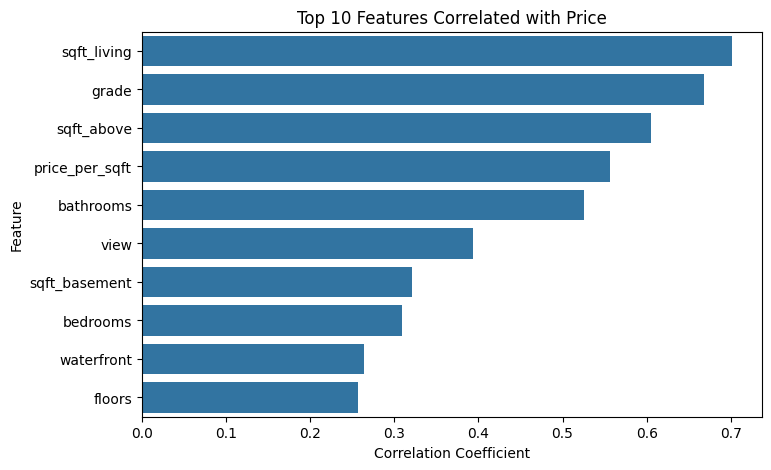

sqft_living      0.702
grade            0.668
sqft_above       0.605
price_per_sqft   0.556
bathrooms        0.526
view             0.393
sqft_basement    0.321
bedrooms         0.309
waterfront       0.264
floors           0.257
Name: price, dtype: float64

In [8]:
price_corr = df[corr_features].corr()['price'].sort_values(ascending=False)[1:11]  # skip self-correlation
sns.barplot(x=price_corr.values, y=price_corr.index)
plt.title("Top 10 Features Correlated with Price")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.savefig("images/top_10_features.png")
plt.show()
display(price_corr)

##### Price Correlation with Living Area

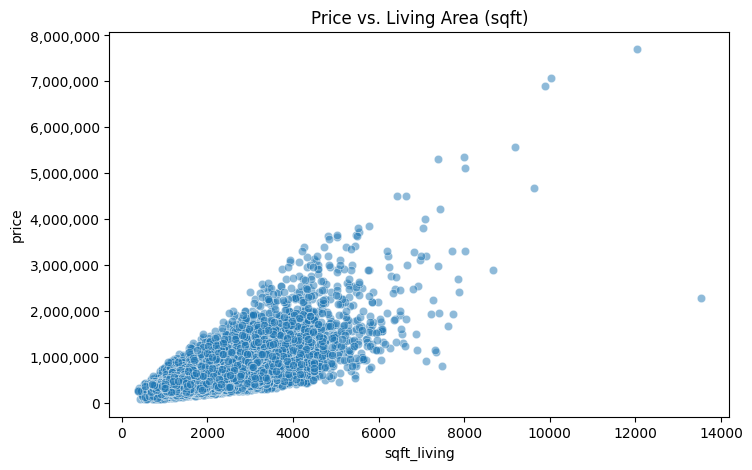

In [9]:
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
sns.scatterplot(x='sqft_living', y='price', data=df, alpha=0.5)
plt.title("Price vs. Living Area (sqft)")
plt.show()

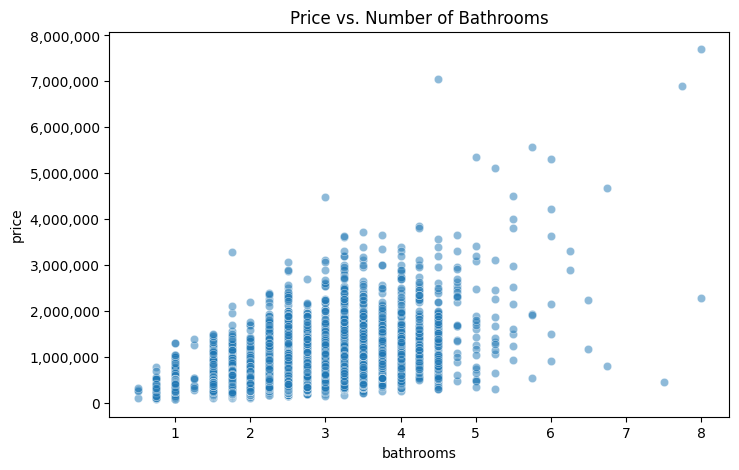

In [10]:
sns.scatterplot(x='bathrooms', y='price', data=df, alpha=0.5)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.title("Price vs. Number of Bathrooms")
plt.show()

#### Renovation ROI

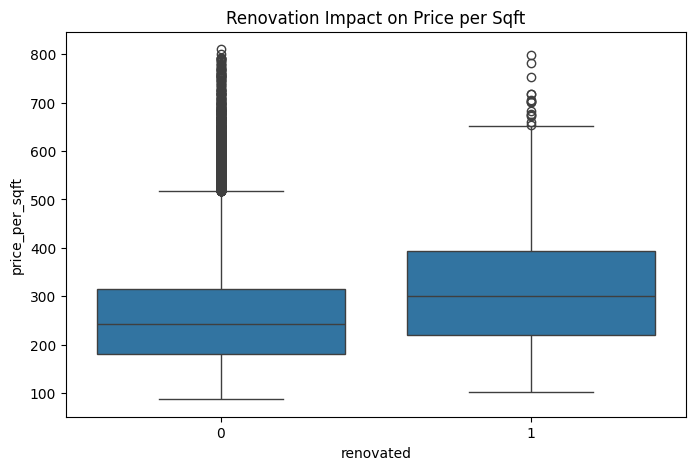

In [11]:
sns.boxplot(x="renovated", y="price_per_sqft", data=df)
plt.title("Renovation Impact on Price per Sqft")
plt.savefig("images/renovation_impact_on_price.png")
plt.show()

This Box Plot above shows the impact of renovation on property prices. 

#### Top 10 Zip Codes by Average Price:

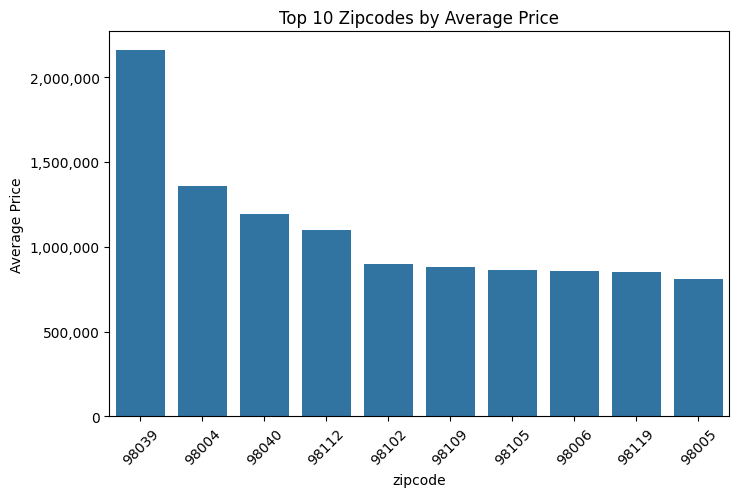

In [12]:
avg_price_zip = df.groupby("zipcode")["price"].mean().sort_values(ascending=False)
sns.barplot(x=avg_price_zip.head(10).index.astype(str), y=avg_price_zip.head(10).values)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=45)
plt.title("Top 10 Zipcodes by Average Price")
plt.ylabel("Average Price")
plt.savefig("images/top_10_zipcodes_by_avg_price.png")
plt.show()

Based on Average price in each area/zipcode, we see the top 10 zipcodes with higher average price

#### Price Trends

##### Average Price by Month Sold

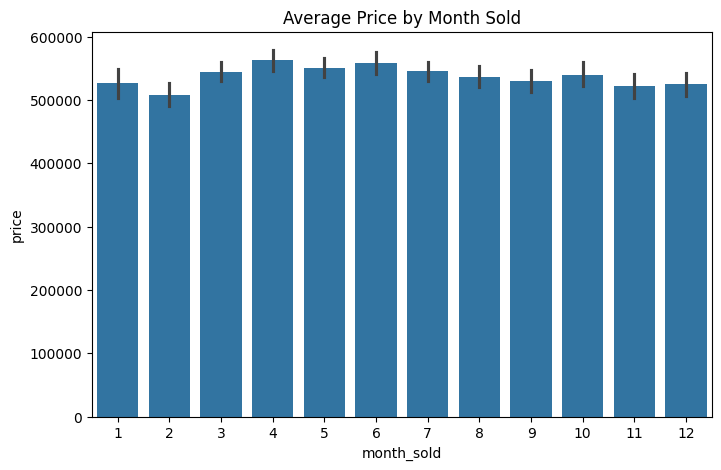

In [13]:
sns.barplot(x="month_sold", y="price", data=df)
plt.title("Average Price by Month Sold")
plt.show()

##### Average Price by Year Sold

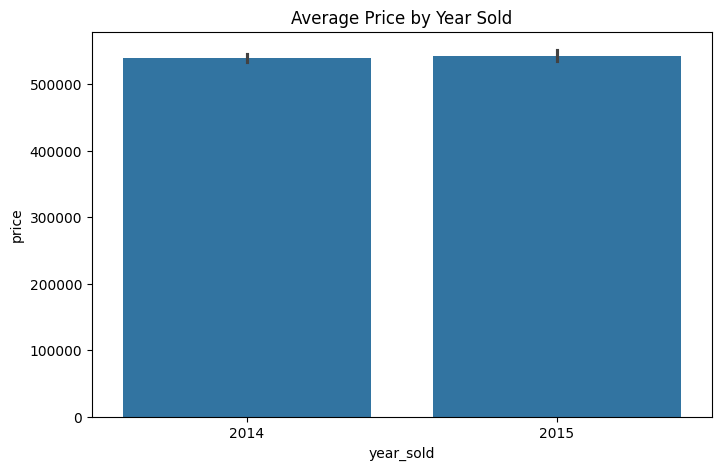

In [14]:
sns.barplot(x="year_sold", y="price", data=df)
plt.title("Average Price by Year Sold")
plt.show()

#### Average Price by Month/Year

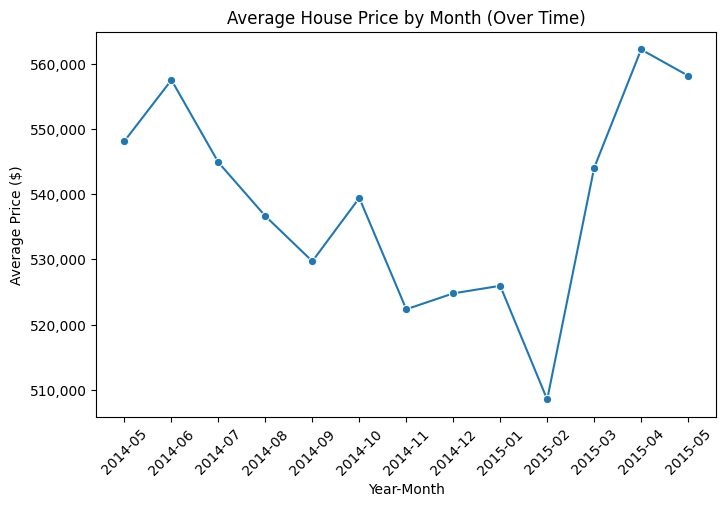

In [15]:
df["date"] = pd.to_datetime(df["date"])
df['year_month'] = df['date'].dt.to_period('M').astype(str)

monthly_avg = df.groupby('year_month')['price'].mean().reset_index()

sns.lineplot(x='year_month', y='price', data=monthly_avg, marker='o')
plt.xticks(rotation=45)
plt.title("Average House Price by Month (Over Time)")
plt.xlabel("Year-Month")
plt.ylabel("Average Price ($)")
plt.ticklabel_format(style='plain', axis='y')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

In [16]:
# df.groupby('year_month')['price'].mean()
df.columns

Index(['date', 'price', 'house_id', 'sale_id', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_sold',
       'month_sold', 'renovated', 'price_per_sqft', 'year_month'],
      dtype='object')

### 4. Geographical Data Analysis

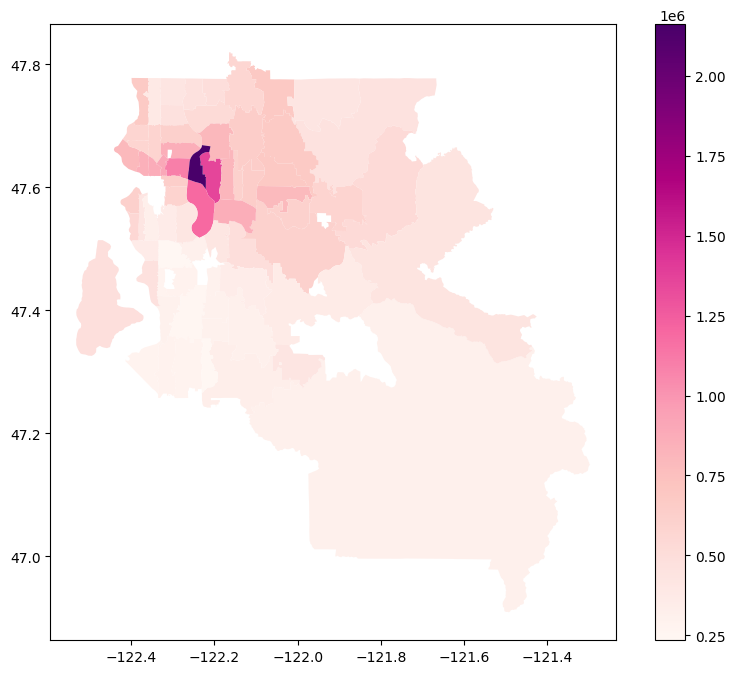

In [37]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["long"], df["lat"]),
    crs="EPSG:4326"
)

zip_shapes = gpd.read_file(
    "data/tl_2023_us_zcta520.zip"  #downloaded the US zipcode data from https://www2.census.gov/geo/tiger/TIGER2023/ZCTA520/tl_2023_us_zcta520.zip
)

gdf["zipcode"] = gdf["zipcode"].astype(str).str.zfill(5)
zip_shapes["ZCTA5CE20"] = zip_shapes["ZCTA5CE20"].astype(str).str.zfill(5)

agg = gdf.groupby("zipcode")["price"].mean().reset_index(name="avg_price")

zip_merged = zip_shapes.merge(agg, left_on="ZCTA5CE20", right_on="zipcode", how="inner")



zip_merged.plot(column="avg_price", cmap="RdPu", legend=True, figsize=(10, 8))

plt.savefig("images/average_price_map.png")
plt.show()

top_zipcodes = zip_merged.sort_values(by="avg_price", ascending=False).head(10)
top_zipcodes[['zipcode', 'avg_price']].to_csv('report/top_10_zip.csv')



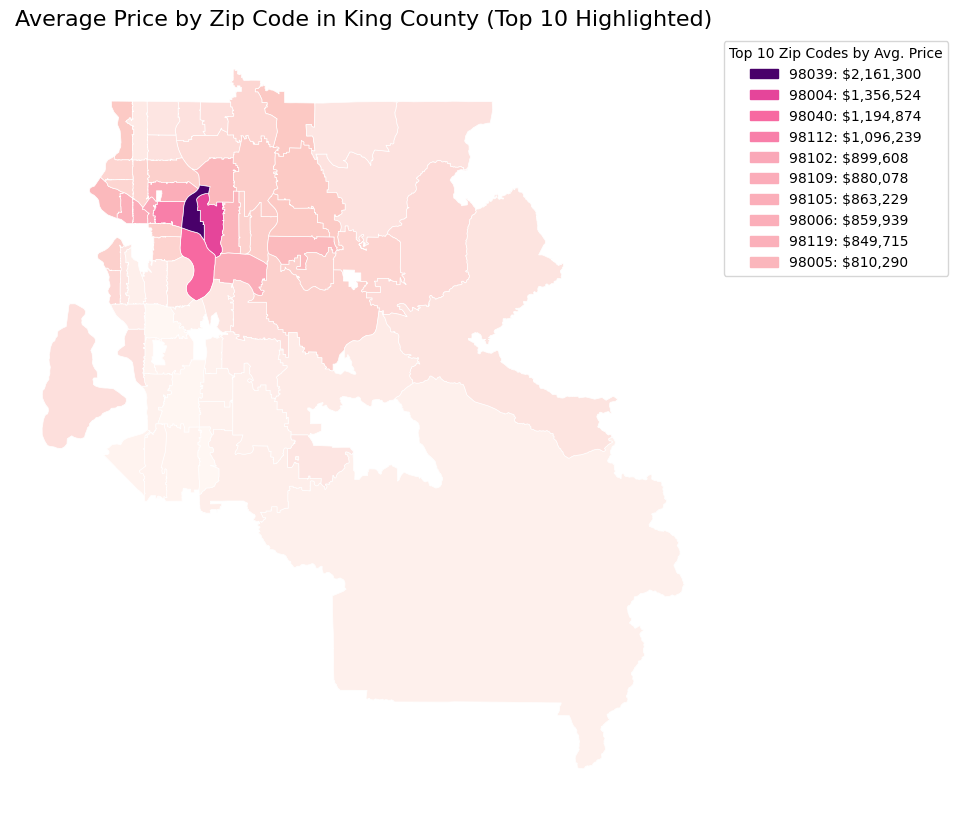

In [35]:
import matplotlib.patches as mpatches

top_zipcodes = zip_merged.sort_values(by="avg_price", ascending=False).head(10)

# --- New Plotting Code ---

# 1. Set up the figure and axes
fig, ax = plt.subplots(1, 1, figsize=(13, 10))

cmap = plt.cm.get_cmap('RdPu')
norm = plt.Normalize(vmin=zip_merged['avg_price'].min(), vmax=zip_merged['avg_price'].max())

zip_merged.plot(column='avg_price', cmap=cmap, norm=norm, linewidth=0.5, ax=ax, edgecolor='white', legend=False)

legend_patches = []
for idx, row in top_zipcodes.iterrows():
    color = cmap(norm(row['avg_price']))
    label = f"{row['zipcode']}: ${row['avg_price']:,.0f}"
    patch = mpatches.Patch(color=color, label=label) # This line will now work
    legend_patches.append(patch)

ax.legend(handles=legend_patches,
          title='Top 10 Zip Codes by Avg. Price',
          bbox_to_anchor=(1, 1),
          loc='upper left',
          fontsize='medium')

ax.set_title('Average Price by Zip Code in King County (Top 10 Highlighted)', fontdict={'fontsize': '16', 'fontweight': '3'})
ax.set_axis_off()

plt.savefig("images/average_price_map_custom_legend.png", dpi=300, bbox_inches='tight')
plt.show()


### 5. Modeling

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

df['zipcode'] = df['zipcode'].astype(str)
df['log_price'] = np.log(df['price'])

df_encoded = pd.get_dummies(df, columns=['zipcode', 'month_sold'], drop_first=True)

time_features = ['year_sold'] + [col for col in df_encoded.columns if 'month_sold_' in col]

x = df_encoded[['sqft_living', 'bathrooms', 'grade', 'condition', 'view', 'waterfront', 'renovated'] +
               [col for col in df_encoded.columns if 'zipcode_' in col] +
               time_features]

y = df_encoded['log_price']

df_features_train, df_features_test, df_price_train, df_price_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(df_features_train, df_price_train)

log_preds = model.predict(df_features_test)

predicted_price = np.exp(log_preds)

r2 = r2_score(np.exp(df_price_test), predicted_price)
mae = mean_absolute_error(np.exp(df_price_test), predicted_price)


print("R²:", r2)
print("MAE:", mae)


R²: 0.7706185418046384
MAE: 77857.65539612864


### 6. Evaluation & Visuals

#### Actual vs. Predicted Prices

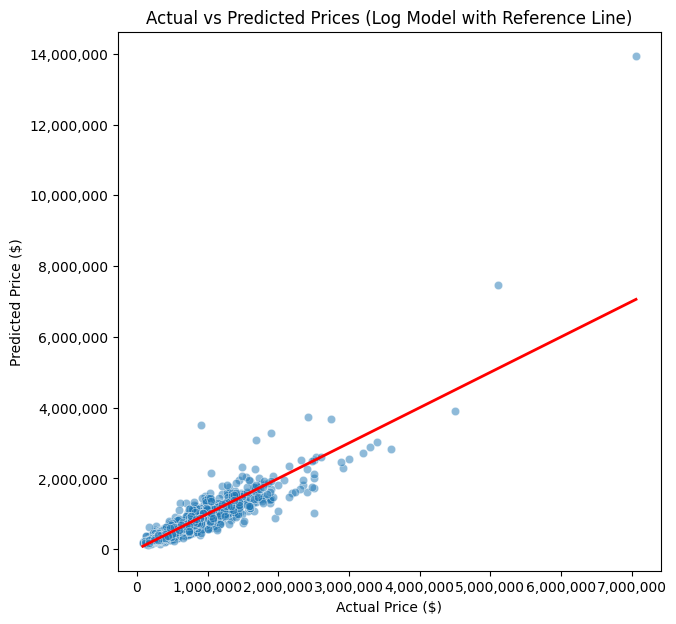

In [19]:
actual = np.exp(df_price_test)
predicted = np.exp(model.predict(df_features_test))

plt.figure(figsize=(7,7))
sns.scatterplot(x=actual, y=predicted, alpha=0.5)
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], color='red', lw=2)  # red diagonal

plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Actual vs Predicted Prices (Log Model with Reference Line)")
plt.ticklabel_format(style='plain', axis='both')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig("images/actual_vs_predicted.png", dpi=300, bbox_inches='tight')
plt.show()

#### Residuals vs. Actual Price

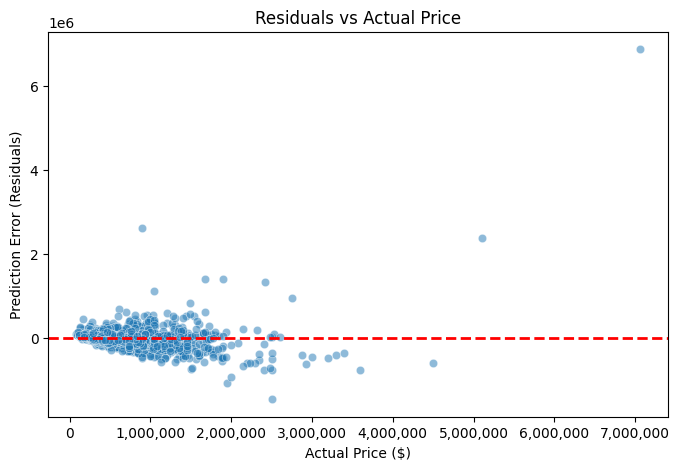

In [20]:
residuals = predicted - actual

sns.scatterplot(x=actual, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.xlabel("Actual Price ($)")
plt.ylabel("Prediction Error (Residuals)")
plt.title("Residuals vs Actual Price")
plt.ticklabel_format(style='plain', axis='x')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig("images/residuals_plot.png", dpi=300, bbox_inches='tight')
plt.show()

### 7. Investment Scenarios

#### Predict with Time in Model

Based on the average house price by month overtime graph we now use the model also to make predictions over time and find what would be the estimated prices during specific times / months.

In [21]:
# example_house_data = {
#     "sqft_living": 2500,   # size of house
#     "bathrooms": 3,        # number of bathrooms
#     "grade": 8,            # quality level
#     "condition": 4,        # overall condition
#     "view": 2,             # scenic view rating
#     "waterfront": 1,       # 0 = no waterfront, 1 = yes
#     "renovated": 0,         # 1 = renovated, 0 = not renovated
#     "zipcode": '98039'
# }

# example_house = pd.DataFrame([example_house_data])

example_house = df_features_test.iloc[[0]].copy()

# example_encoded = pd.get_dummies(example_house, columns=['zipcode'])

# example_aligned = example_encoded.reindex(columns=df_features_train.columns, fill_value=0)

# --- Scenario 1: Predict price for a sale in January (Month 1) ---
# Turn off all month indicators. January (month 1) becomes the baseline because of drop_first=True.
for col in example_house.columns:
    if 'month_sold_' in col:
        example_house[col] = 0

pred_jan = model.predict(example_house)
price_jan = np.exp(pred_jan[0])

# --- Scenario 2: Predict price for a sale in June (Month 6) ---
# Now, simply activate the indicator for June.
example_house['month_sold_6'] = 1

pred_jun = model.predict(example_house)
price_jun = np.exp(pred_jun[0])

# --- Scenario 3: Predict price for a sale in April (Month 4) ---
# Now, simply activate the indicator for April.
example_house['month_sold_4'] = 1

pred_april = model.predict(example_house)
price_april = np.exp(pred_april[0])

# --- Scenario 4: Predict price for a sale in Feb (Month 2) ---
# Now, simply activate the indicator for FEB.
example_house['month_sold_2'] = 1

pred_feb = model.predict(example_house)
price_feb = np.exp(pred_feb[0])

# --- Scenario 5: Predict price for a sale in October (Month 10) ---
# Now, simply activate the indicator for OCT.
example_house['month_sold_10'] = 1

pred_oct = model.predict(example_house)
price_oct = np.exp(pred_oct[0])


# Model predicts in log scale → convert back to price
# predicted_log_price = model.predict(example_aligned)
# predicted_price = np.exp(predicted_log_price)

# print(f"Estimated market value: ${predicted_price[0]:,.0f}")

# --- Compare the results ---
print(f"Estimated Price for a January Sale: ${price_jan:,.0f}")
print(f"Estimated Price for a February Sale: ${price_feb:,.0f}")
print(f"Estimated Price for a April Sale:    ${price_april:,.0f}")
print(f"Estimated Price for a June Sale:    ${price_jun:,.0f}")
print(f"Estimated Price for a October Sale:    ${price_oct:,.0f}")
# print("-" * 40)
# print(f"Seasonal Price Difference:        +${price_jun - price_jan:,.0f}")


Estimated Price for a January Sale: $224,108
Estimated Price for a February Sale: $274,076
Estimated Price for a April Sale:    $269,057
Estimated Price for a June Sale:    $250,886
Estimated Price for a October Sale:    $302,314


#### Predicted Price by Month

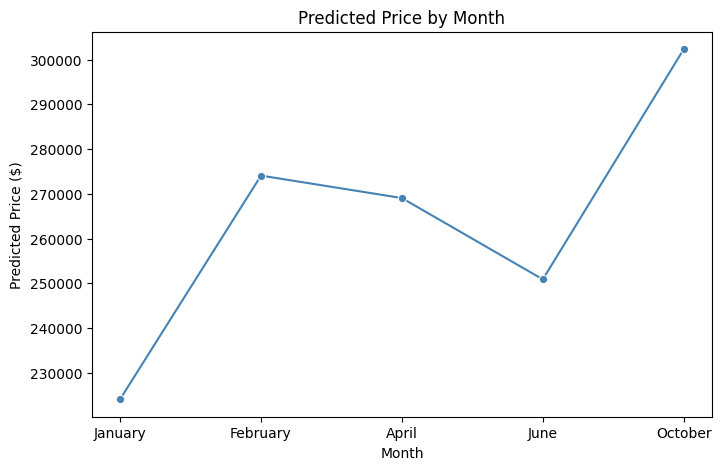

In [22]:
months = ["January", "February", "April", "June", "October"]
prices = [price_jan, price_feb, price_april, price_jun, price_oct]

sns.lineplot(x=months, y=prices, marker='o', color='steelblue')
plt.title("Predicted Price by Month")
plt.ylabel("Predicted Price ($)")
plt.xlabel("Month")
plt.ticklabel_format(style='plain', axis='y')
plt.savefig("images/predicted_price_by_month.png", dpi=300, bbox_inches='tight')
plt.show()

#### Predicted Price For All Months

--- Estimated Price by Month of Sale ---


,Month,Estimated_Price_Formatted
0,January,"$224,108"
1,February,"$228,288"
2,March,"$234,526"
3,April,"$240,340"
4,May,"$244,911"
5,June,"$250,886"
6,July,"$249,046"
7,August,"$249,587"
8,September,"$247,959"
9,October,"$247,198"


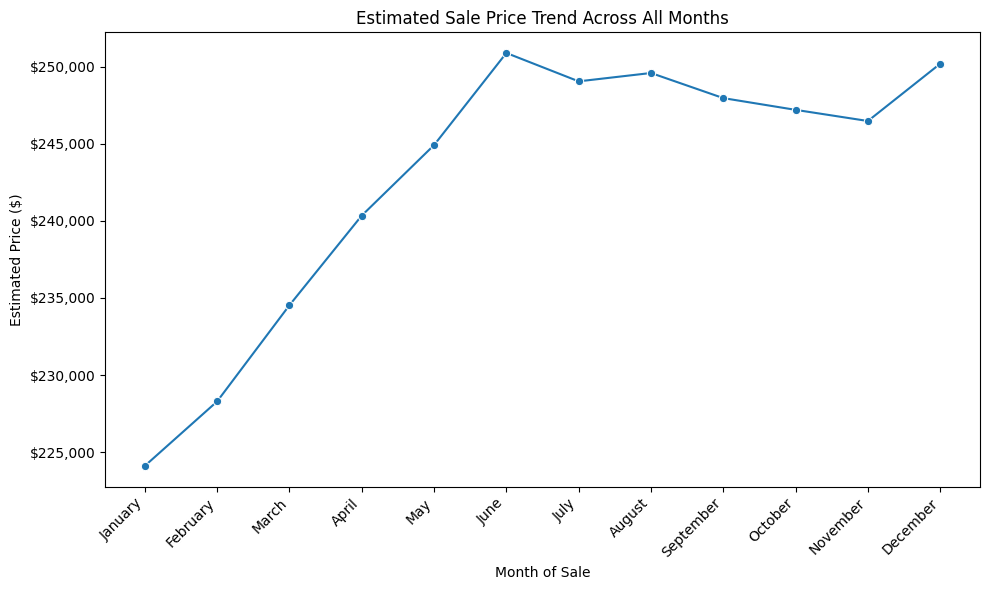

In [39]:
import calendar

all_months_house = example_house.copy()

monthly_predictions = {}

# Loop through each month of the year
for month_num in range(1, 13):
    # Reset all month indicators to 0
    for col in all_months_house.columns:
        if 'month_sold_' in col:
            all_months_house[col] = 0
            
    # Activate the indicator for the current month, if it's not the baseline (January)
    if month_num > 1:
        month_col = f'month_sold_{month_num}'
        if month_col in all_months_house.columns:
            all_months_house[month_col] = 1
        else:
            # If the column doesn't exist, it means this month was never in the training data
            continue 

    # Predict the log price and convert it back
    predicted_log_price = model.predict(all_months_house)
    estimated_price = np.exp(predicted_log_price[0])
    
    # Store the result with the month name
    month_name = calendar.month_name[month_num]
    monthly_predictions[month_name] = estimated_price

# --- Display Results in a Table ---
price_trends_df = pd.DataFrame(list(monthly_predictions.items()), columns=['Month', 'Estimated_Price'])
price_trends_df['Estimated_Price_Formatted'] = price_trends_df['Estimated_Price'].apply(lambda x: f'${x:,.0f}')

print("--- Estimated Price by Month of Sale ---")
display(price_trends_df[['Month', 'Estimated_Price_Formatted']])


# --- Visualize the Monthly Price Trend ---
plt.figure(figsize=(10, 6))
sns.lineplot(x='Month', y='Estimated_Price', data=price_trends_df, marker='o', sort=False)

plt.title("Estimated Sale Price Trend Across All Months")
plt.xlabel("Month of Sale")
plt.ylabel("Estimated Price ($)")
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.show()

In [40]:
log_preds_all = log_preds
estimated_prices = np.exp(log_preds_all)
actual_prices = np.exp(df_price_test)

results_df = df.loc[df_features_test.index].copy()

results_df['actual_price'] = actual_prices
results_df['estimated_price'] = estimated_prices
results_df['potential_uplift'] = results_df['estimated_price'] - results_df['actual_price']

top_3_investments = results_df.sort_values(by='potential_uplift', ascending=False).head(3)
top_3_investments['zipcode'] = top_3_investments['zipcode'].astype(int)
top_3_investments


,date,price,house_id,sale_id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,sqft_lot15,year_sold,month_sold,renovated,price_per_sqft,year_month,log_price,actual_price,estimated_price,potential_uplift
3910,2014-06-11,7060000.000,9808700762,3911,5.000,4.500,10040.000,37325.000,2.000,1.000,...,25449.000,2014,6,1,703.187,2014-06,15.770,7060000.000,13931477.337,6871477.337
21034,2015-02-19,900000.000,2424059170,21035,5.000,6.000,7120.000,40806.000,2.000,0.000,...,36859.000,2015,2,0,126.404,2015-02,13.710,900000.000,3513872.184,2613872.184
1162,2014-10-20,5110000.000,1247600105,1163,5.000,5.250,8010.000,45517.000,2.000,1.000,...,26788.000,2014,10,0,637.953,2014-10,15.447,5110000.000,7476798.057,2366798.057


### 8. Insights & Recommendations

In [24]:
display_df = top_3_investments.copy()

for col in ['actual_price', 'estimated_price', 'potential_uplift']:
    display_df[col] = display_df[col].apply(lambda x: f"${x:,.0f}")

display_df['potential_uplift'] = display_df['potential_uplift'].str.replace('$', '+')

def format_characteristics(row):
    renovated_status = 'Yes' if row.get('renovated', 0) != 0 else 'No'
    renovated_year = row['yr_renovated']
    waterfront_status = 'Yes' if row.get('waterfront', 0) == 1 else 'No'
    return (f"Grade: {row['grade']} | Condition: {row['condition']} | Sqft: {row['sqft_living']:,} | Renovated: {renovated_status} | Renovated Year: {renovated_year} | Waterfront: {waterfront_status}")

display_df['key_characteristics'] = display_df.apply(format_characteristics, axis=1)

final_report = display_df[[
    'house_id',
    'zipcode',
    'actual_price',
    'estimated_price',
    'potential_uplift',
    'key_characteristics'
]]

final_report.index = [f"Rank #{i+1}" for i in range(len(final_report))]

print("--- Top 3 Investment Opportunities for Charles Christensen ---")
print("These properties have the largest gap between their actual sale price and their model-estimated value.\n")
display(final_report)



--- Top 3 Investment Opportunities for Charles Christensen ---
These properties have the largest gap between their actual sale price and their model-estimated value.



,house_id,zipcode,actual_price,estimated_price,potential_uplift,key_characteristics
Rank #1,9808700762,98004,"$7,060,000","$13,931,477","+6,871,477","Grade: 11 | Condition: 3 | Sqft: 10,040.0 | Re..."
Rank #2,2424059170,98006,"$900,000","$3,513,872","+2,613,872","Grade: 12 | Condition: 3 | Sqft: 7,120.0 | Ren..."
Rank #3,1247600105,98033,"$5,110,000","$7,476,798","+2,366,798","Grade: 12 | Condition: 3 | Sqft: 8,010.0 | Ren..."


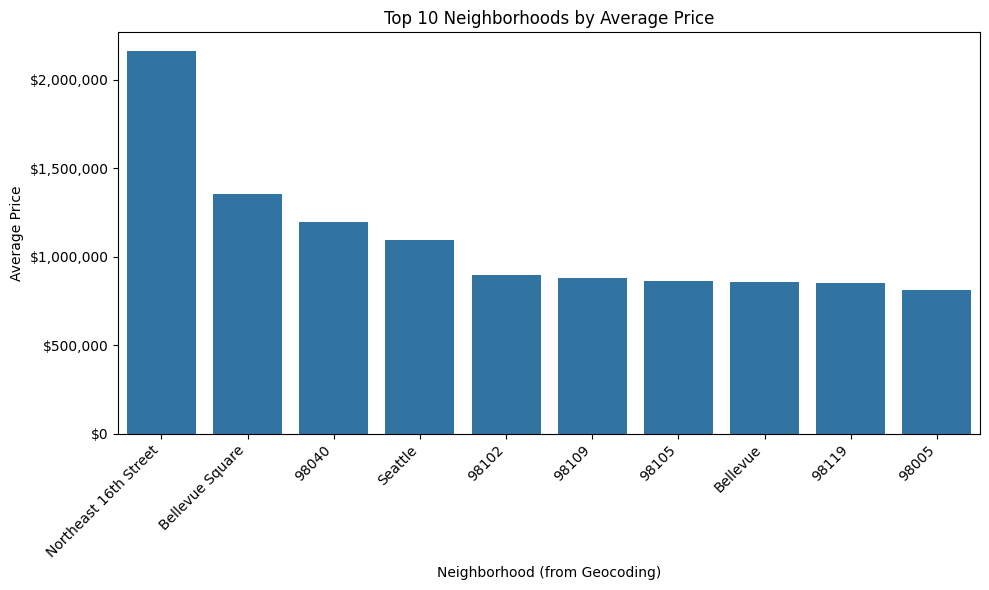

In [25]:
zip_grouped = df.groupby('zipcode').agg({
    'price': 'mean',
    'lat': 'mean',
    'long': 'mean'
}).sort_values(by='price', ascending=False).head(10)

gdf_zip = gpd.GeoDataFrame(
    zip_grouped,
    geometry=gpd.points_from_xy(zip_grouped['long'], zip_grouped['lat']),
    crs="EPSG:4326"
)

try:
    locations = gpd.tools.reverse_geocode(gdf_zip.geometry)
    
    neighborhood_labels = locations['address'].apply(lambda x: x.split(',')[2].strip()).tolist()

except Exception as e:
    print(f"Reverse geocoding failed: {e}. Falling back to zip codes for labels.")
    neighborhood_labels = gdf_zip.index.astype(str).tolist()


plt.figure(figsize=(10, 6))
sns.barplot(x=neighborhood_labels, y=gdf_zip['price'].values)

plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Neighborhoods by Average Price")
plt.xlabel("Neighborhood (from Geocoding)")
plt.ylabel("Average Price")
plt.tight_layout()
plt.show()

In [26]:
final_report['house_id'] = final_report['house_id'].astype(str)
final_report.dtypes

house_id               object
zipcode                 int64
actual_price           object
estimated_price        object
potential_uplift       object
key_characteristics    object
dtype: object

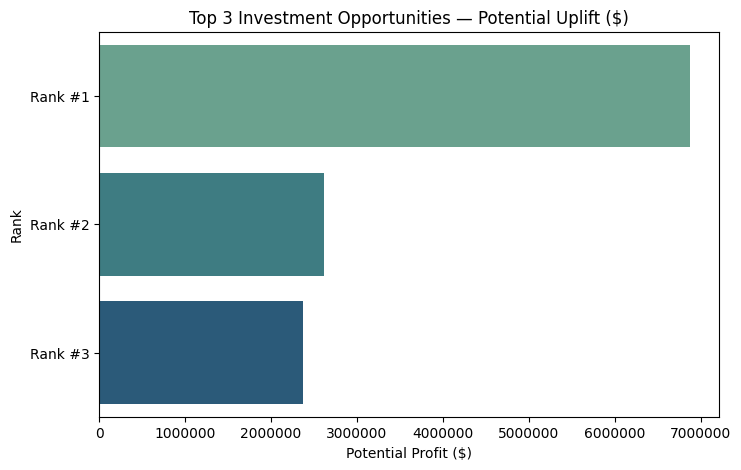

In [27]:
sns.barplot(
    x='potential_uplift',
    y=final_report.index,
    data=top_3_investments,
    palette='crest'
)
plt.title("Top 3 Investment Opportunities — Potential Uplift ($)")
plt.xlabel("Potential Profit ($)")
plt.ylabel("Rank")
plt.ticklabel_format(style='plain', axis='x')
plt.savefig("images/top3_potential_uplift.png", dpi=300, bbox_inches='tight')
plt.show()

#### Investment Insights

The predictive model was used to simulate how different sale timings and property characteristics impact final sale prices.  
The analysis reveals which properties are **currently undervalued** based on model-predicted fair market value.

The following table lists the **Top 3 Investment Opportunities for Charles Christensen** —  
houses that were sold significantly below their estimated true value.  
These represent **potential high-return investments** through renovation or strategic resale.

**Interpretation:**
- **Actual Market Value:** The house’s recorded sale price in the dataset.  
- **Estimated Market Value:** The model’s predicted fair price based on all property features.  
- **Potential Uplift:** The gap between the model-estimated and actual prices — the profit margin if the property is resold at true market value.  
- **Key Characteristics:** Quick overview of grade, condition, size, and renovation potential.

The results clearly show:
- High-grade properties in premium zipcodes (98004, 98006, 98033) remain undervalued relative to their attributes.  
- Renovation potential and location quality are strong drivers of resale gains.  
- **Seasonality simulations indicate October as the most favorable month for selling**, followed by February and April, while **January shows the weakest market performance.**  
- Listing or selling during October could yield the highest potential returns.

The export file `investment_report_charles_christensen.csv` contains detailed insights for review.


### 9. Export Report (CSV)

In [28]:
final_report.to_csv('report/investment_report_charles_christensen.csv')

In [29]:
print(example_house)

      sqft_living  bathrooms  grade  condition  view  waterfront  renovated  \
3686      850.000      0.750      6          3 0.000       0.000          0   

      zipcode_98002  zipcode_98003  zipcode_98004  ...  month_sold_3  \
3686          False          False          False  ...             0   

      month_sold_4  month_sold_5  month_sold_6  month_sold_7  month_sold_8  \
3686             1             0             1             0             0   

      month_sold_9  month_sold_10  month_sold_11  month_sold_12  
3686             0              1              0              0  

[1 rows x 88 columns]


In [41]:
average_price = df['price'].mean()
average_price

np.float64(540296.5735055795)